In [1]:
import tensorflow as tf
from tensorflow import keras 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

DIR = 'Filter_Model/'

AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT = 24
RES_WIDTH = 32
NUM_CLASS = 5
N_BATCH =8
N_EPOCH = 100
LR = 0.0005

2024-01-30 13:08:35.097468: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 13:08:35.138376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 13:08:35.926194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset1_origin = np.load('npz/dataset1_origin.npz', allow_pickle=True)
dataset1_horizon = np.load('npz/dataset1_horizon.npz', allow_pickle=True)
dataset1_vertical = np.load('npz/dataset1_vertical.npz', allow_pickle=True)
dataset1_vh = np.load('npz/dataset1_vh.npz', allow_pickle=True)
dataset2_origin = np.load('npz/dataset2_origin.npz', allow_pickle=True)
dataset2_horizon = np.load('npz/dataset2_horizon.npz', allow_pickle=True)
dataset2_vertical = np.load('npz/dataset2_vertical.npz', allow_pickle=True)
dataset2_vh = np.load('npz/dataset2_vh.npz', allow_pickle=True)

d1o_origin_images, d1o_target_images, d1o_number_labels, d1o_coordinates = dataset1_origin['images'], dataset1_origin['filters'], dataset1_origin['numbers'],  dataset1_origin['coordinates']
d1h_origin_images, d1h_target_images, d1h_number_labels, d1h_coordinates = dataset1_horizon['images'], dataset1_horizon['filters'], dataset1_horizon['numbers'],  dataset1_horizon['coordinates']
d1v_origin_images, d1v_target_images, d1v_number_labels, d1v_coordinates = dataset1_vertical['images'], dataset1_vertical['filters'], dataset1_vertical['numbers'],  dataset1_vertical['coordinates']
d1vh_origin_images, d1vh_target_images, d1vh_number_labels, d1vh_coordinates = dataset1_vh['images'], dataset1_vh['filters'], dataset1_vh['numbers'],  dataset1_vh['coordinates']
d2o_origin_images, d2o_target_images, d2o_number_labels, d2o_coordinates = dataset2_origin['images'], dataset2_origin['filters'], dataset2_origin['numbers'],  dataset2_origin['coordinates']
d2h_origin_images, d2h_target_images, d2h_number_labels, d2h_coordinates = dataset2_horizon['images'], dataset2_horizon['filters'], dataset2_horizon['numbers'],  dataset2_horizon['coordinates']
d2v_origin_images, d2v_target_images, d2v_number_labels, d2v_coordinates = dataset2_vertical['images'], dataset2_vertical['filters'], dataset2_vertical['numbers'],  dataset2_vertical['coordinates']
d2vh_origin_images, d2vh_target_images, d2vh_number_labels, d2vh_coordinates = dataset2_vh['images'], dataset2_vh['filters'], dataset2_vh['numbers'],  dataset2_vh['coordinates']

origin_images = np.concatenate([d1o_origin_images, d2o_origin_images, d1h_origin_images, d2h_origin_images, d1v_origin_images, d2v_origin_images, d1vh_origin_images, d2vh_origin_images], axis = 0)
target_images = np.concatenate([d1o_target_images, d2o_target_images, d1h_target_images, d2h_target_images, d1v_target_images, d2v_target_images, d1vh_target_images, d2vh_target_images], axis = 0)
numbers_labels = np.concatenate([d1o_number_labels, d2o_number_labels, d1h_number_labels, d2h_number_labels, d1v_number_labels, d2v_number_labels, d1vh_number_labels, d2vh_number_labels], axis = 0)
coordinates = np.concatenate([d1o_coordinates, d2o_coordinates, d1h_coordinates, d2h_coordinates, d1v_coordinates, d2v_coordinates, d1vh_coordinates, d2vh_coordinates], axis = 0)

print(origin_images.shape)
print(target_images.shape)
print(numbers_labels.shape)
print(coordinates.shape)


(13276, 24, 32)
(13276, 24, 32)
(13276,)
(13276, 4, 8)


In [3]:
origin_images = origin_images.reshape(13276, 24, 32, 1)
print(origin_images.shape)
target_images = target_images.reshape(13276, 24, 32, 1)
print(target_images.shape)

(13276, 24, 32, 1)
(13276, 24, 32, 1)


In [4]:
print(origin_images.max(), origin_images.min())
origin_images = origin_images / origin_images.max()
print(origin_images.max(), origin_images.min())
print(origin_images.shape)


print(target_images.max(), target_images.min())
target_images = target_images / target_images.max()
print(target_images.max(), target_images.min())
print(target_images.shape)


255 0
1.0 0.0
(13276, 24, 32, 1)
255 0
1.0 0.0
(13276, 24, 32, 1)


In [5]:
# def resize_and_pad_image(image, target, label, min_side=96, max_side=128):
    
#     # image_shape = tf.cast(tf.shape(image)[:2], dtype = tf.float32)
#     # ratio = min_side / tf.reduce_min(image_shape)
#     # if ratio * tf.reduce_max(image_shape) > max_side:
#     #   ratio = max_side / tf.reduce_max(image_shape)

#     # new_image_shape = ratio * image_shape

#     # image = tf.image.resize(image, 
#     #                         tf.cast(new_image_shape, dtype=tf.int32), 
#     #                         method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
#     target_shape = tf.cast(tf.shape(target)[:2], dtype = tf.float32)
#     ratio = min_side / tf.reduce_min(target_shape)
#     if ratio * tf.reduce_max(target_shape) > max_side:
#       ratio = max_side / tf.reduce_max(target_shape)

#     new_target_image_shape = ratio * target_shape

#     target = tf.image.resize(target, 
#                             tf.cast(new_target_image_shape, dtype=tf.int32),)
#                             # method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    

#     return image, target, label


In [6]:
# from sklearn.model_selection import train_test_split
# train_images, val_images,  train_target, val_target, train_labels, val_labels = train_test_split(
#     origin_images, target_images, numbers_labels, test_size=0.3, random_state=42
# )

In [7]:
def one_hot_encode(image, target, label):
    label = tf.one_hot(label, depth=NUM_CLASS)
    return image, target, label

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((origin_images, target_images, numbers_labels))

2024-01-30 13:08:41.922123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22041 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-01-30 13:08:41.924187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22292 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-01-30 13:08:41.926045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22292 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-01-30 13:08:41.927883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22292 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

In [9]:
# train_ds = train_ds.map(resize_and_pad_image)

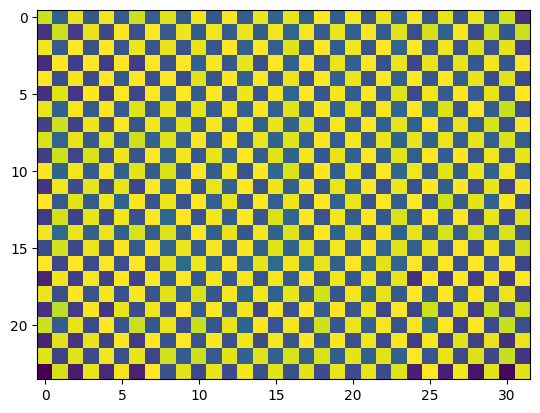

(24, 32, 1)
tf.Tensor(0, shape=(), dtype=int64)


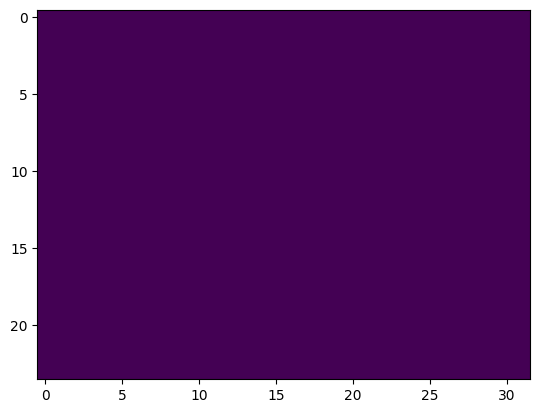

(24, 32, 1)


In [10]:
for img, target, label in train_ds.take(1):
    plt.imshow(img)
    plt.show()
    print(img.shape)
    print(label)
    plt.imshow(target)
    plt.show()
    print(target.shape)
    

In [11]:
train_ds = train_ds.map(one_hot_encode)

In [12]:
train_ds = train_ds.shuffle(buffer_size=len(origin_images)).batch(1).prefetch(buffer_size = AUTOTUNE)

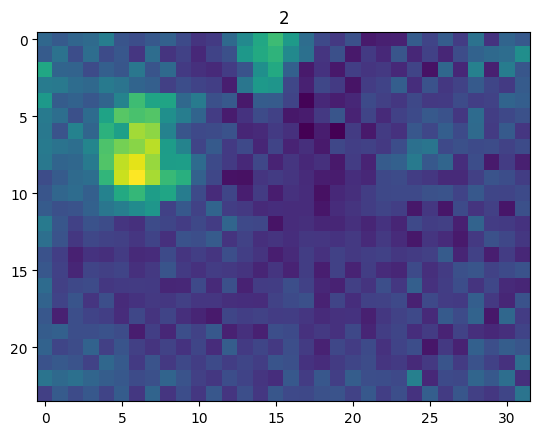

(24, 32, 1)


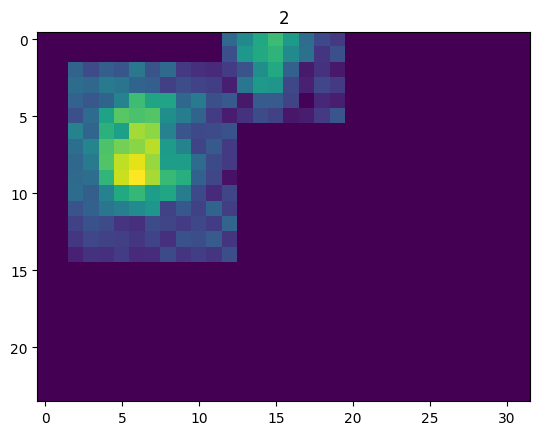

(24, 32, 1)


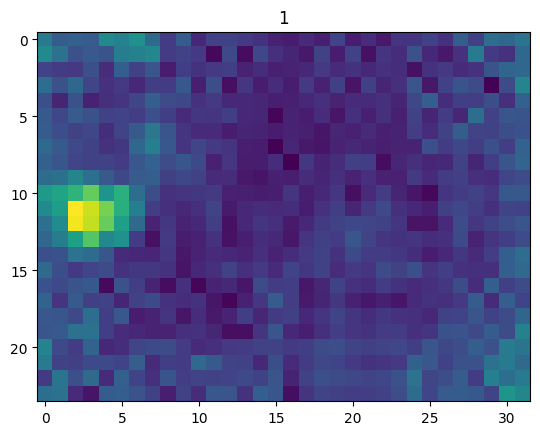

(24, 32, 1)


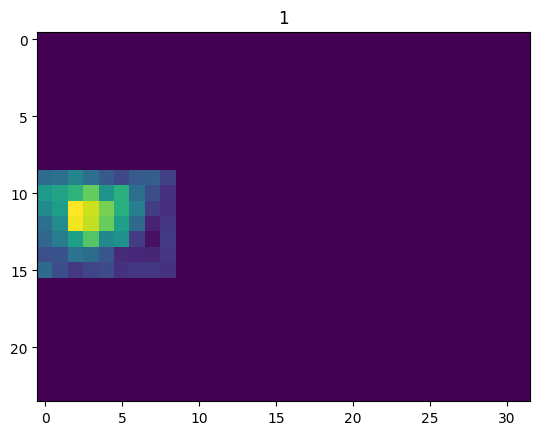

(24, 32, 1)


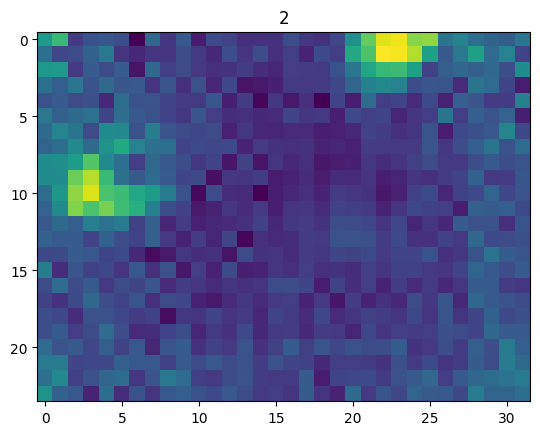

(24, 32, 1)


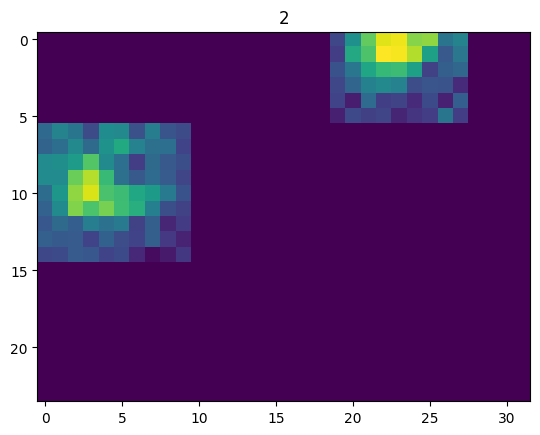

(24, 32, 1)


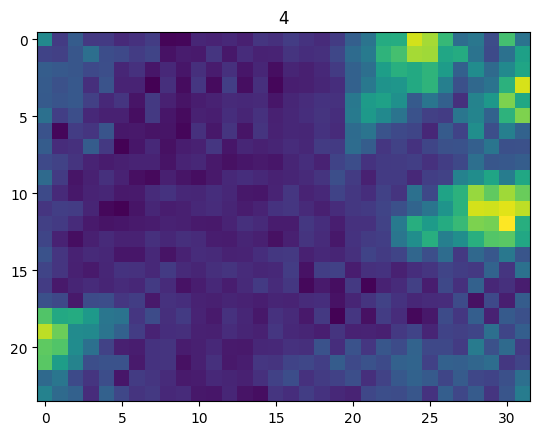

(24, 32, 1)


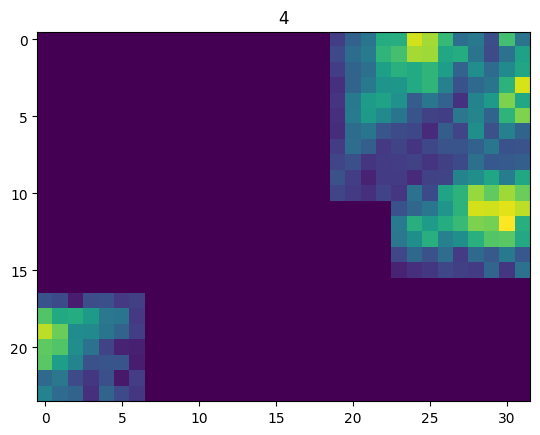

(24, 32, 1)


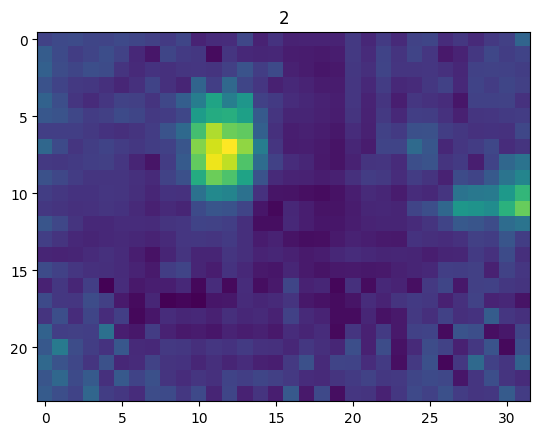

(24, 32, 1)


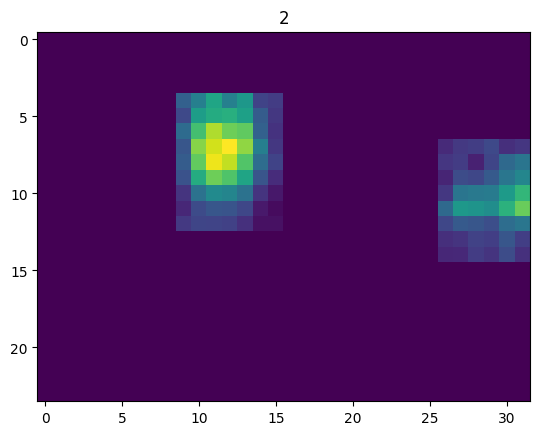

(24, 32, 1)


In [13]:
for images, targets, labels in train_ds.take(5):
    plt.imshow(images[0].numpy())
    plt.title(str(labels[0].numpy().argmax()))
    plt.show()
    print(images[0].shape)

    plt.imshow(targets[0].numpy())
    plt.title(str(labels[0].numpy().argmax()))
    plt.show()
    print(targets[0].shape)

In [14]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Activation
from keras.layers import Input, GlobalAveragePooling2D, Conv2D, ReLU, Reshape, Multiply
from keras.layers import BatchNormalization, Dropout, ZeroPadding2D, Concatenate
from keras.models import Model
from tensorflow.keras.layers import Input, Lambda
from keras.layers import ZeroPadding2D, DepthwiseConv2D
from keras.regularizers import l2
from keras.layers import Add
import tensorflow as tf

class BackBone(tf.keras.Model):
    def __init__(self):
        super(BackBone, self).__init__()
        self.l2_regularizer = l2(0.001)

    def squeeze_excite_block(self, input_tensor, ratio=8):
        """ Squeeze and Excitation block """
        channels = input_tensor.shape[-1]

        x = GlobalAveragePooling2D()(input_tensor)
        x = Reshape((1, 1, channels))(x)

        x = Conv2D(channels // ratio, (1, 1), padding='same')(x)
        x = ReLU()(x)
        x = Conv2D(channels, (1, 1), padding='same')(x)
        x = tf.keras.activations.sigmoid(x)
        out = Multiply()([input_tensor, x])
        return out

    def residual_layer(self, feature_map, latent, name:str):
        """ Residual block """
        add_layer = Add(name = name+'_output')([feature_map, latent])
        return add_layer

    def feature_extraction_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_1')(feature_map)
        feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        feature_map = Activation('relu')(feature_map)
        feature_map = DepthwiseConv2D(kernel_size=3, padding = 'same')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        feature_map = Dropout(0.3)(feature_map)

        feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_3')(feature_map)
        feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 2, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_4')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        feature_map = Activation('relu')(feature_map)
        feature_map = self.squeeze_excite_block(feature_map)
        return feature_map

    def convolutional_residual_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_1')(feature_map)
        latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(feature_map)
        latent = BatchNormalization()(latent)
        latent = Activation('relu')(latent)
        latent = DepthwiseConv2D(kernel_size=3, padding = 'same')(latent)
        latent = Dropout(0.3)(latent)

        latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_3')(latent)
        latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_4')(latent)
        latent = BatchNormalization()(latent)
        latent = Activation('relu')(latent)
        residual_block = self.residual_layer(feature_map, latent, name)
        return residual_block
    
    def normalize_image(self, image):
        # 입력 이미지의 최대값으로 나누어 정규화
        return image / tf.reduce_max(image)


    def conditional_normalize(self, image):
        # 입력 이미지의 최대값이 1보다 큰 경우에만 정규화 수행
        return tf.cond(tf.reduce_max(image) > 1, lambda: self.normalize_image(image), lambda: image)



    def __call__(self, input_shape=(24, 32, 1)):
        inputs_image = Input(shape=input_shape)

        normalized_inputs = Lambda(self.conditional_normalize)(inputs_image)
        
        upscale_inputs_image = Conv2DTranspose(filters = 4, kernel_size = 3, strides = 4,
						padding = 'same')(normalized_inputs)
        upscale_inputs_image = Activation('relu')(upscale_inputs_image)
        upscale_inputs_image = BatchNormalization()(upscale_inputs_image)
        block_1 = self.feature_extraction_block(inputs_image, 8, 16, 'block_1')
        block_1_output = self.convolutional_residual_block(block_1, 8, 16,'block_2')
        block_2 = self.feature_extraction_block(block_1_output, 8, 16, 'block_3')
        block_2_output = self.convolutional_residual_block(block_2, 8, 16, 'block_4')
        block_3 = self.feature_extraction_block(block_2_output, 8, 16, 'block_5')
        block_3_output = self.convolutional_residual_block(block_3, 8, 16, 'block_6')
        # block_4 = self.feature_extraction_block(block_3_output, 8, 16, 'block_7')
        # block_4_output = self.convolutional_residual_block(block_4, 8, 16, 'block_8')

        latent = GlobalAveragePooling2D()(block_3_output)
        # number_dense = Dense(32, activation='relu')(latent)
        number_output = Dense(5, activation='softmax', name='number_output', dtype='float32')(latent)
        
        flatten = Flatten()(block_3_output)
        latent_vector = Dense(units = 16)(flatten)
        latent_vector = Dense(3 * 4 * 16)(latent_vector)
        latent_vector = Reshape(target_shape = (3, 4, 16))(latent_vector)
        
        filtered_image = Conv2DTranspose(filters = 8, kernel_size = 3, strides = 2,
						padding = 'same')(latent_vector)
        filtered_image = Concatenate()([filtered_image, block_2_output])

        filtered_image = Conv2DTranspose(filters = 8, kernel_size = 3, strides = 2,
					    padding = 'same')(filtered_image)
        filtered_image = Concatenate()([filtered_image, block_1_output])

        filtered_image = Activation('relu')(filtered_image)
        filtered_image = BatchNormalization()(filtered_image)
        filtered_image = Conv2DTranspose(filters = 8, kernel_size = 3, strides = 2,
						padding = 'same')(filtered_image)
        filtered_image = Concatenate()([filtered_image, inputs_image])
        filtered_image_outputs = Conv2DTranspose(filters = 1, kernel_size = 3, strides = 1,
						padding = 'same', activation = 'sigmoid', name = 'filtered_image_outputs')(filtered_image)
        
    


        model = Model(inputs = inputs_image, outputs = (filtered_image_outputs, number_output))
        return model

In [15]:
backbone = BackBone()
model = backbone()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 block_1_1 (Conv2D)          (None, 24, 32, 8)            80        ['input_1[0][0]']             
                                                                                                  
 block_1_2 (Conv2D)          (None, 24, 32, 8)            584       ['block_1_1[0][0]']           
                                                                                                  
 batch_normalization_1 (Bat  (None, 24, 32, 8)            32        ['block_1_2[0][0]']           
 chNormalization)                                                                             

In [16]:
import tensorflow as tf
from keras.metrics import Precision, Recall
from keras.callbacks import ModelCheckpoint

backbone = BackBone()
model = backbone()

initial_learning_rate = LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.60,
    staircase=True)

# lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=3,
#     min_lr=1e-6,
#     verbose=1)

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     backbone = BackBone()
#     model = backbone()
#     optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy', Precision(), Recall()])
#     checkpoint = ModelCheckpoint('v4_backbone_1_best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, 
              loss={'filtered_image_outputs': 'mse', 'number_output': 'categorical_crossentropy'}, 
              metrics={'filtered_image_outputs': ['accuracy'], 'number_output': ['accuracy', Precision(), Recall()]})



checkpoint = ModelCheckpoint('Filter_Model/model/filter_model.h5', monitor='val_number_output_accuracy', verbose=1, save_best_only=True, mode='max')

# model.summary()

In [17]:
# from keras.utils import plot_model

# plot_model(model, to_file='./detection_model.png', show_shapes=True, show_layer_names=True)
# Image(filename='detection_model.png')

In [18]:
from tensorflow.keras.callbacks import TensorBoard

log_dir = DIR
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [19]:
for image, target, label in train_ds.take(1):
    print(image.shape)
    print(target.shape)
    print(label.shape)

(1, 24, 32, 1)
(1, 24, 32, 1)
(1, 5)


In [20]:
images = []
targets = []
labels = []
for image, target, label in train_ds:
    images.append(image[0])
    targets.append(target[0])
    labels.append(label[0])

images = np.array(images)
targets = np.array(targets)
labels = np.array(labels)

print(images.shape)
print(targets.shape)
print(labels.shape)

(13276, 24, 32, 1)
(13276, 24, 32, 1)
(13276, 5)


In [21]:
hist = model.fit(
    images, (targets, labels),
    validation_split=0.3,
    batch_size=32,
    epochs=N_EPOCH,
    verbose=1,  
    callbacks=[checkpoint, tensorboard_callback]
)

# tensorboard --logdir=Final/v10_final --bind_all

Epoch 1/100


2024-01-30 13:09:04.471690: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-30 13:09:06.318649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-01-30 13:09:07.121166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-30 13:09:07.372038: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc48801a420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-30 13:09:07.372085: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-30 13:09:07.372102: I tensorflow/compiler/xla/service/service.cc:176]   Stream

291/291 [==============================] - ETA: 0s - loss: 1.4767 - filtered_image_outputs_loss: 0.0552 - number_output_loss: 1.1845 - filtered_image_outputs_accuracy: 0.7608 - number_output_accuracy: 0.5376 - number_output_precision: 0.6447 - number_output_recall: 0.2879
Epoch 1: val_number_output_accuracy improved from -inf to 0.20286, saving model to Filter_Model/model/filter_model.h5
291/291 [==============================] - 31s 49ms/step - loss: 1.4767 - filtered_image_outputs_loss: 0.0552 - number_output_loss: 1.1845 - filtered_image_outputs_accuracy: 0.7608 - number_output_accuracy: 0.5376 - number_output_precision: 0.6447 - number_output_recall: 0.2879 - val_loss: 2.0101 - val_filtered_image_outputs_loss: 0.0328 - val_number_output_loss: 1.7449 - val_filtered_image_outputs_accuracy: 0.7947 - val_number_output_accuracy: 0.2029 - val_number_output_precision: 0.2029 - val_number_output_recall: 0.2029
Epoch 2/100
291/291 [==============================] - ETA: 0s - loss: 1.0462 - 

In [22]:
# plt.plot(hist.history['loss'], label = 'loss')
# plt.plot(hist.history['accuracy'], label = 'accuracy')
# plt.plot(hist.history['val_loss'], label = 'val_loss')
# plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
# plt.legend(loc = 'upper left')

# plt.savefig('filter_model.png')

In [2]:
print(images[22000].shape)
image = images[22000]
expand_image = np.expand_dims(image, axis = 0)
print(expand_image.shape)

NameError: name 'images' is not defined

In [3]:
plt.imshow(image)
plt.show()

NameError: name 'plt' is not defined

In [4]:
noise_removed_image, people_count = model.predict(expand_image)
noise_removed_image = noise_removed_image[0]
noise_removed_image = ((noise_removed_image - np.min(noise_removed_image)) / (np.max(noise_removed_image) - np.min(noise_removed_image)) * 255).astype(np.uint8)
print(noise_removed_image.shape)
print(noise_removed_image.max())
print(noise_removed_image.min())
plt.imshow(noise_removed_image)
plt.show()
print(np.argmax(people_count[0]))

NameError: name 'model' is not defined

In [44]:
qq!!

SyntaxError: invalid syntax (1088857786.py, line 1)

In [ ]:
model2.save('./v3_3().h5')

In [ ]:
import tensorflow as tf
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep

# train_dataset, train_number_labels,

# 초기 모델 로드
model = tf.keras.models.load_model('./v4_backbone_1_best_model.h5')

# 프루닝 설정
epochs = 1
batch_size = 128
num_train_samples = sum(1 for _ in val_ds)
end_step = np.ceil(num_train_samples / batch_size).astype(np.int32) * epochs
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                 final_sparsity=0.80,
                                                 begin_step=0,
                                                 end_step=end_step)
}

# 모델에 프루닝 래퍼 적용
model_for_pruning = sparsity.prune_low_magnitude(model, **pruning_params)

# 프루닝 모델 컴파일 및 훈련
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.categorical_crossentropy,
                          metrics=['accuracy'])

callbacks = [
    UpdatePruningStep()
]

model_for_pruning.fit(val_ds, epochs=epochs, callbacks=callbacks)

# 프루닝 제거 및 최종 모델 저장
final_model = sparsity.strip_pruning(model_for_pruning)
final_model.save('pruned_model.h5')


In [ ]:
final_model.summary()

In [ ]:
batch_size = 1
# train_dataset_tf = tf.data.Dataset.from_tensor_slices(test_dataset)
# train_dataset을 배치로 만듦
# batched_train_dataset = train_dataset_tf.batch(batch_size)

In [ ]:
import tensorflow as tf

# 기존 모델 로드
model = tf.keras.models.load_model('v4_backbone_1_best_model.h5')

# 대표 데이터셋을 준비하는 함수
def representative_data_gen():
    for input_value, _ in val_ds.take(100):  # val_ds의 각 요소는 (data, label) 튜플
        # data 부분만 추출하고 float32 타입으로 캐스팅
        yield [tf.cast(input_value, tf.float32).numpy()]

# 훈련 데이터셋을 로드하고 배치 처리
# 여기서 val_ds는 이미 tf.data.Dataset 형식이고, batch_size는 적절한 값으로 설정해야 합니다.
batched_train_dataset = val_ds.batch(batch_size)
batched_train_dataset = batched_train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), y))  # x는 입력 데이터, y는 레이블

# TFLite 변환기 설정
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# 모든 연산을 float32로 제한
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# 입력과 출력을 float32로 설정
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# 모델을 TFLite 모델로 변환
tflite_quant_model = converter.convert()

# TFLite 모델 저장
with open('quantized_model_v1.tflite', 'wb') as f:
    f.write(tflite_quant_model)
